<a href="https://colab.research.google.com/github/BSniegowski/ML-uni_course/blob/main/lab/08_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#@title imports
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#@title Demo
dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={'size': 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

In [34]:
#@title MyModel
class MyModel(torch.nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv = torch.nn.Sequential(
        torch.nn.Conv2d(3, 32, kernel_size=9, stride=4, padding=2),
        torch.nn.BatchNorm2d(32),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3, stride=1),
        torch.nn.Conv2d(32, 32, kernel_size=5, padding=1),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(),
        torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3, stride=1),
    )
    self.adaptivepool = torch.nn.AdaptiveAvgPool2d((6, 6))
    self.classifier = torch.nn.Sequential(
        torch.nn.Linear(128*6*6, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(512, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(512, 10),
    )
    
  def forward(self, x):
    x = self.conv(x)
    x = self.adaptivepool(x)
    x = torch.flatten(x, start_dim=1)
    x = self.classifier(x)
    return x

In [6]:
#@title show results
def show_results(logs):
  f, ax = plt.subplots(1, 2, figsize=(16, 5))
  ax[0].plot(logs['train_accuracy'], color='C%s' % i, linestyle='--', label='train')
  ax[0].plot(logs['test_accuracy'], color='C%s' % i, label='test')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(logs['train_loss'], color='C%s' % i, linestyle='--', label='train')
  ax[1].plot(logs['test_loss'], color='C%s' % i, label='test')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

In [30]:
#@title DataLoaders
train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=Compose([ToTensor()]))

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=Compose([ToTensor()]))


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


Device:  cuda:0


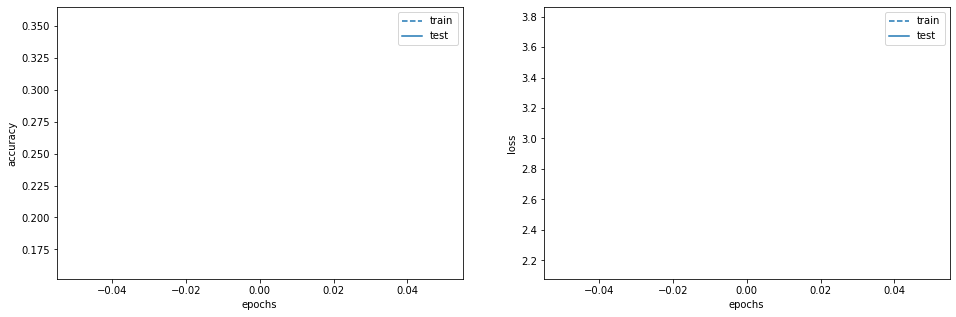

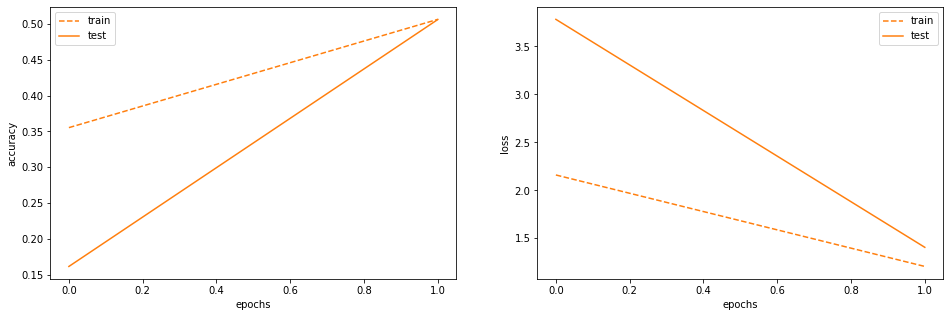

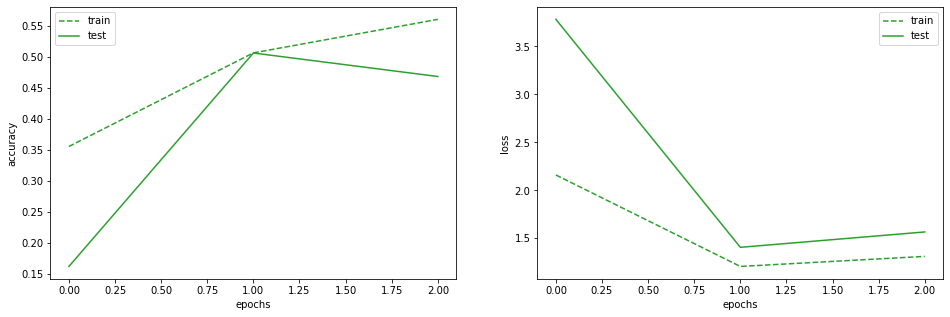

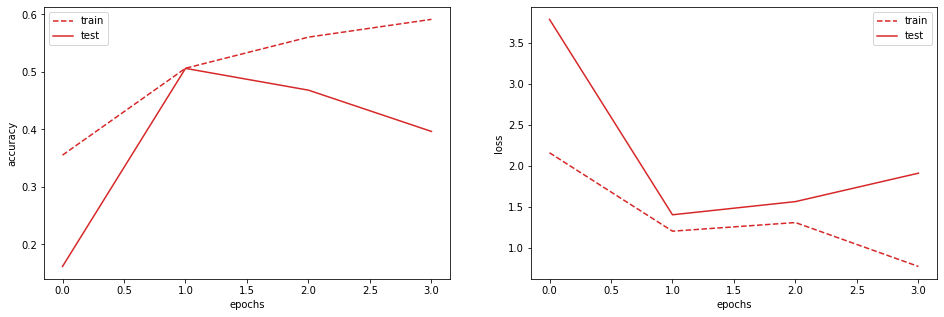

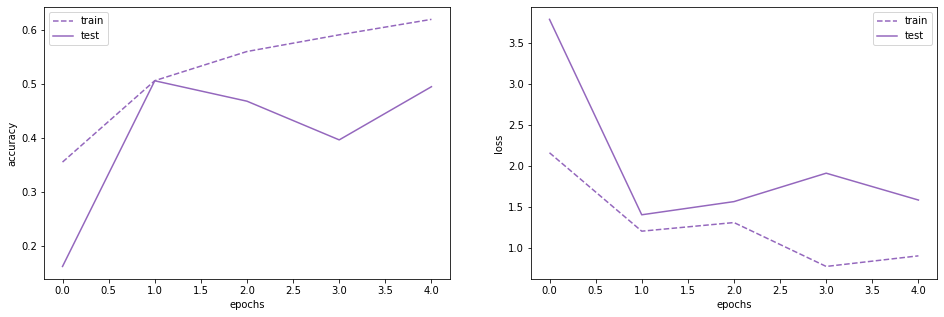

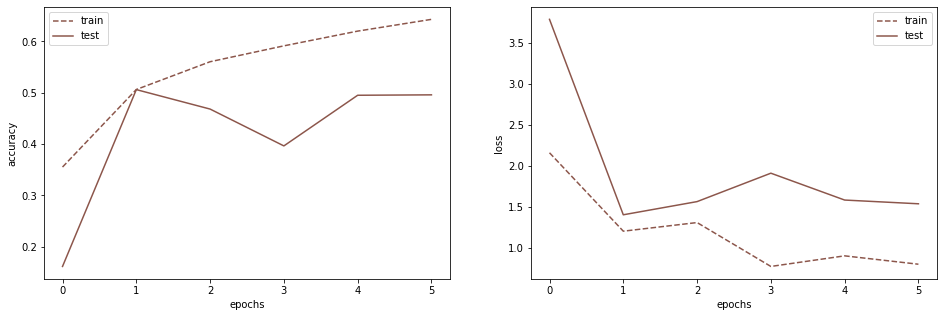

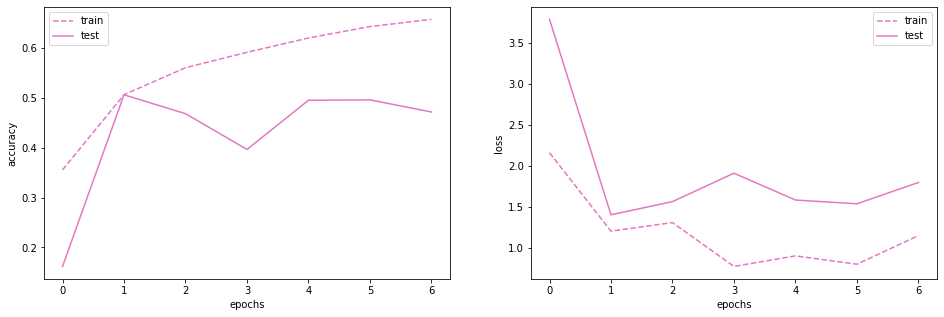

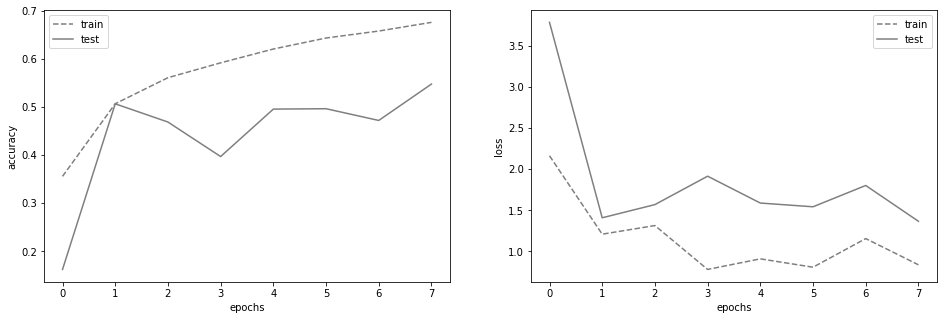

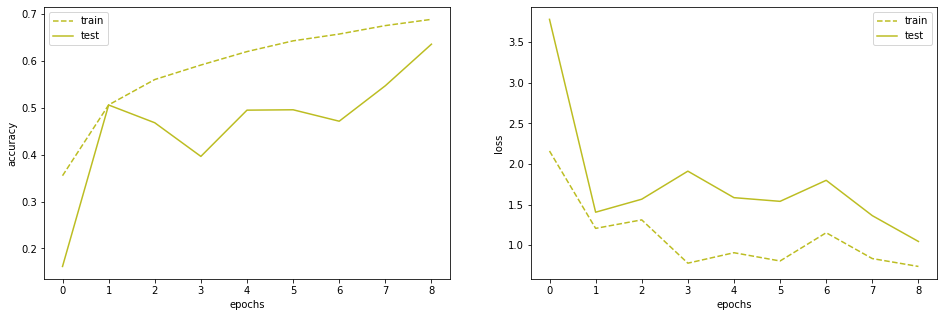

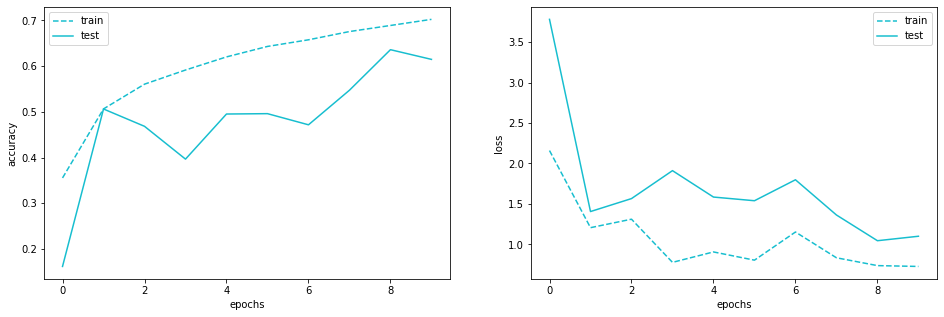

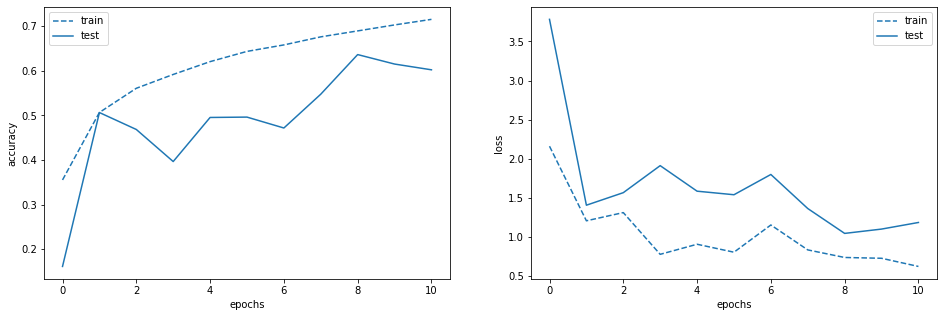

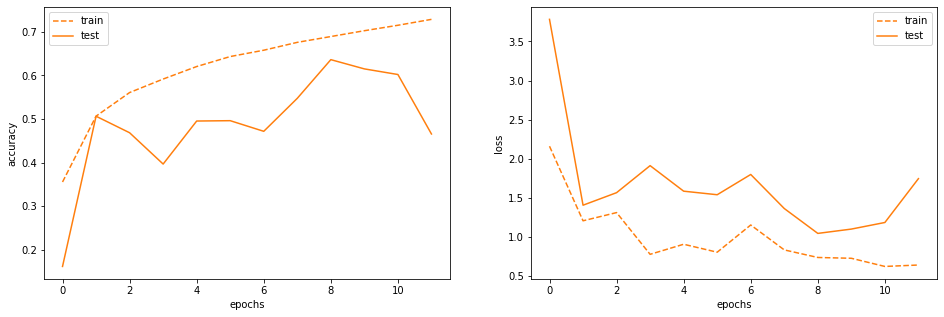

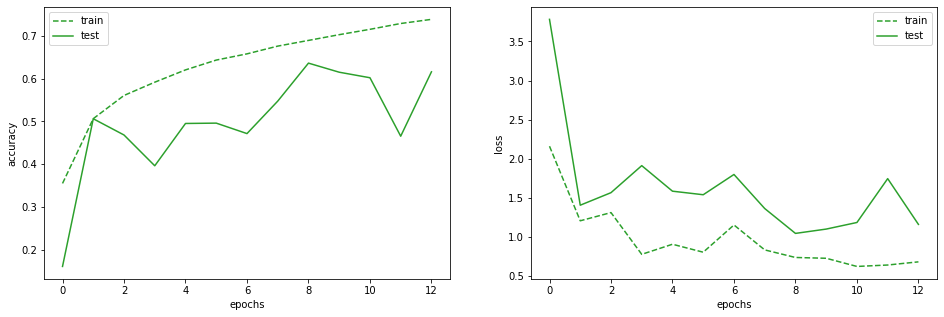

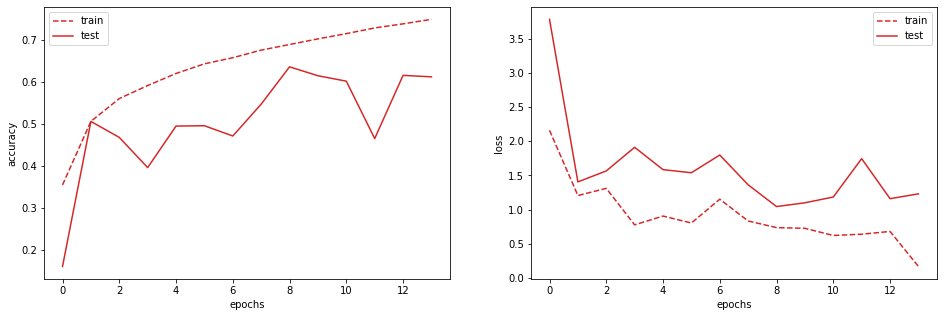

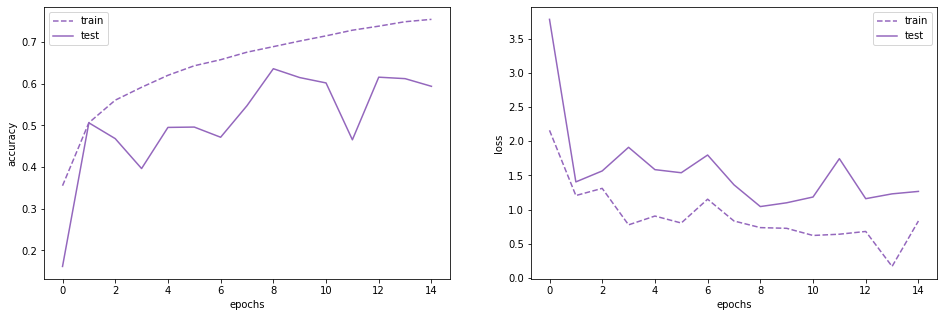

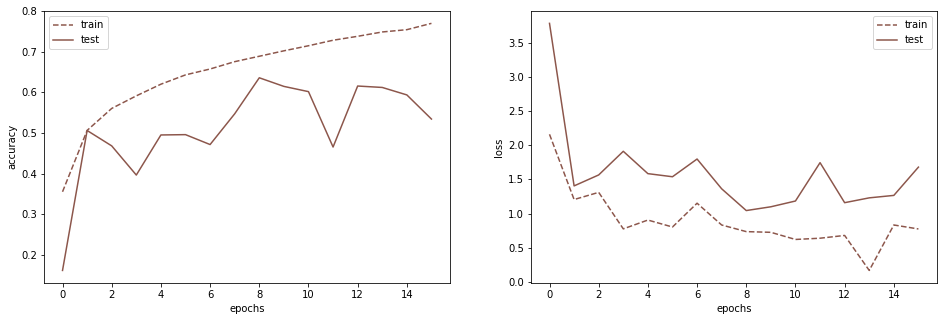

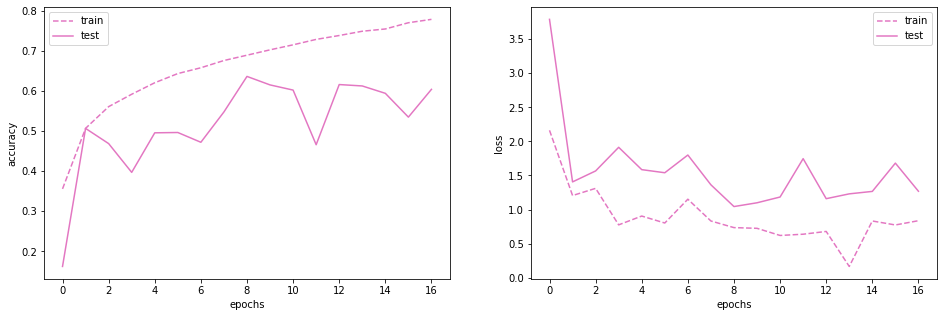

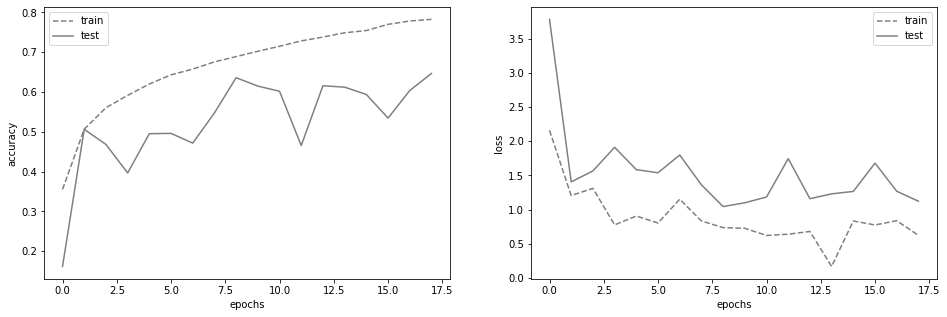

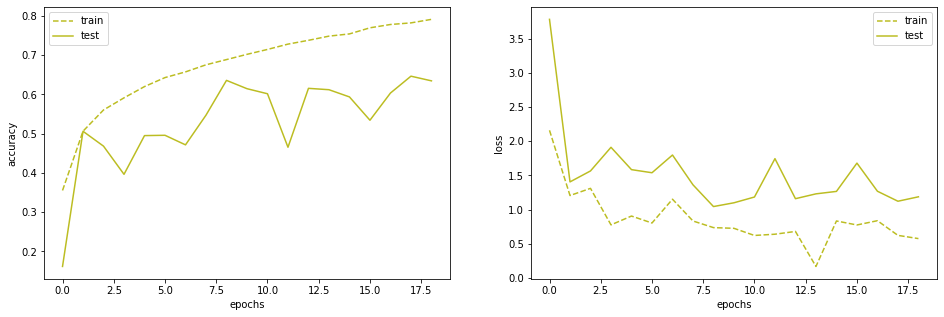

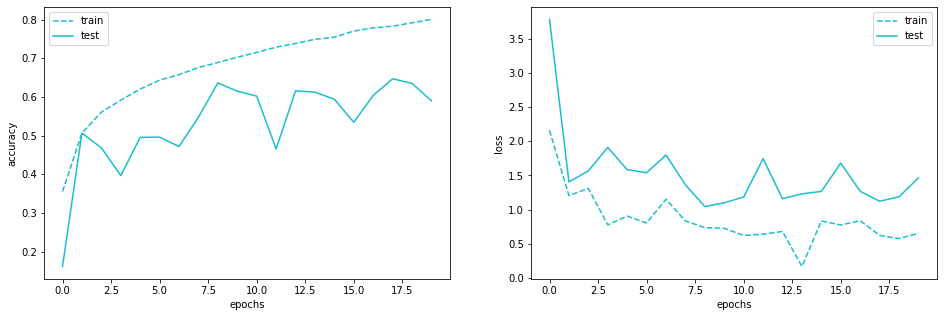

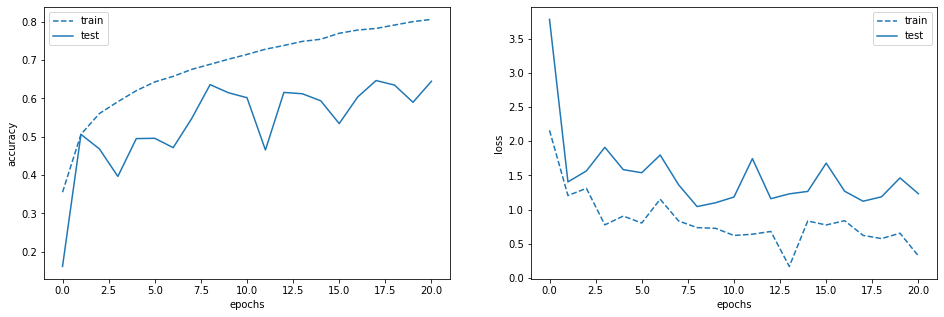

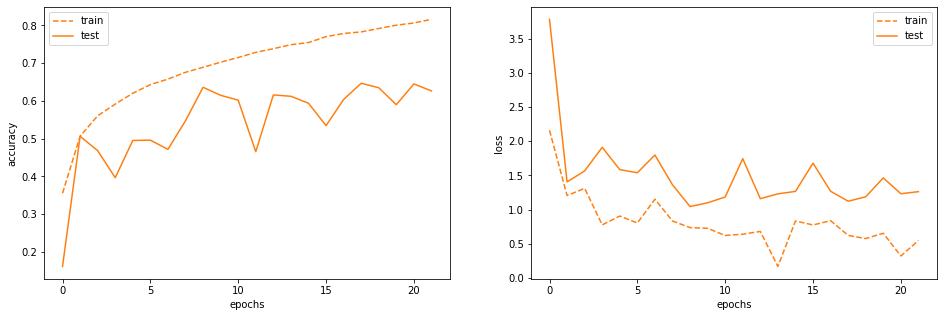

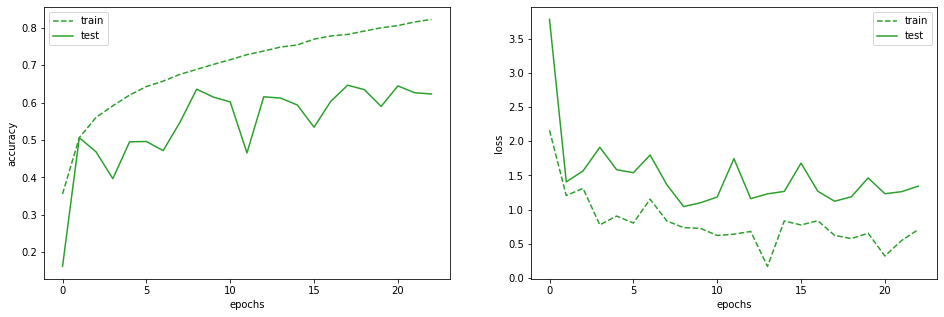

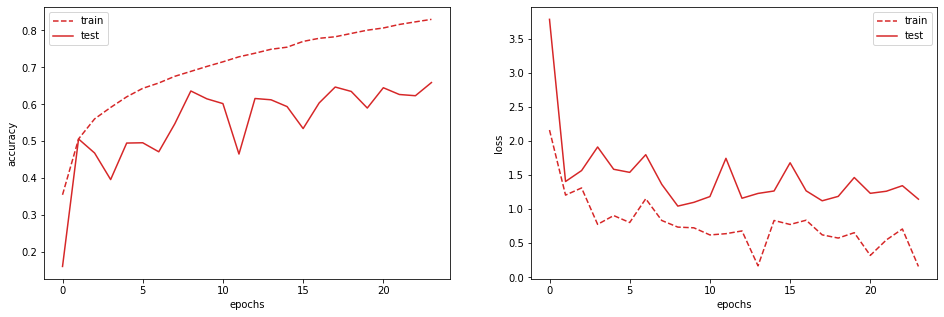

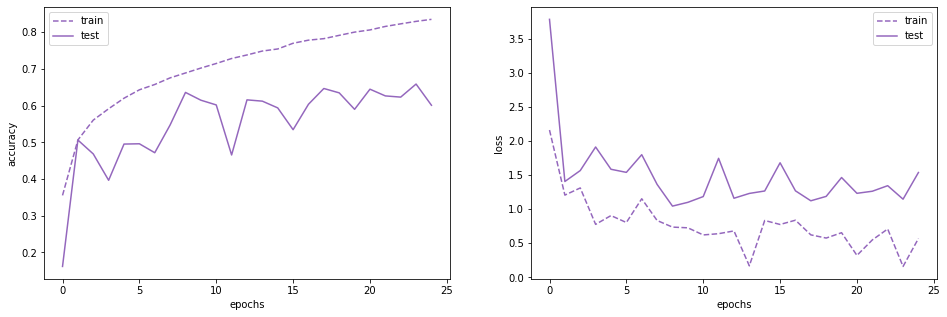

In [ ]:
#@title Training loop
model = MyModel()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: ', device)
model.to(device)

# Hiperparameters
learning_rate = 0.05
momentum = 0.1
n_epochs = 500

loss_fn = torch.nn.functional.cross_entropy
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# for it in model.parameters():
#   print(it.size())

# for x, y in train_loader:
#   print(x.size())
#   output = layer(x)
#   print((output.reshape(output.shape[0],-1)).size())
#   break

logs = {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}
correct, numel = 0, 0

# for i in range(5):
#   print(i)
#   logs['test_accuracy'].append(torch.randint(low=0,high=10,size=(1,)))
#   logs['train_accuracy'].append(torch.randint(low=0,high=10,size=(1,)))
#   logs['test_loss'].append(torch.randint(low=0,high=10,size=(1,)))
#   logs['train_loss'].append(torch.randint(low=0,high=10,size=(1,)))
#   show_results(logs)
#   plt.pause(1e-10)
#   time.sleep(1)

# Training loop
for i in range(n_epochs):
  # print('test acc', logs['test_accuracy'])
  model.train()
  for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    output = model(x)
    y_pred = torch.argmax(output, dim=1)
    correct += torch.sum(y_pred == y).item()
    numel += train_loader.batch_size
    loss = loss_fn(output, y)
    loss.backward()
    optimizer.step()

  logs['train_loss'].append(loss.item())
  logs['train_accuracy'].append(correct / numel)
  correct, numel = 0, 0

  model.eval()
  with torch.no_grad():
    for x_test, y_test in test_loader:
      x_test = x_test.to(device)
      y_test = y_test.to(device)
      output = model(x_test)
      y_pred = torch.argmax(output, dim=1)
      correct += torch.sum(y_pred == y_test).item()
      numel += test_loader.batch_size
    loss = loss_fn(output, y_test)

  logs['test_loss'].append(loss.item())
  logs['test_accuracy'].append(correct / numel)
  correct, numel = 0, 0
  show_results(logs)
  plt.pause(1e-10)